##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# CycleGAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cyclegan"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook demonstrates unpaired image to image translation using conditional GAN's, as described in [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593), also known as CycleGAN. The paper proposes a method that can capture the characteristics of one image domain and figure out how these characteristics could be translated into another image domain, all in the absence of any paired training examples. 

This notebook assumes you are familiar with Pix2Pix, which you can learn about in the [Pix2Pix tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix). The code for CycleGAN is similar, the main difference is an additional loss function, and the use of unpaired training data.

CycleGAN uses a cycle consistency loss to enable training without the need for paired data. In other words, it can translate from one domain to another without a one-to-one mapping between the source and target domain. 

This opens up the possibility to do a lot of interesting tasks like photo-enhancement, image colorization, style transfer, etc. All you need is the source and the target dataset (which is simply a directory of images).

![Output Image 1](images/horse2zebra_1.png)
![Output Image 2](images/horse2zebra_2.png)

## Set up the input pipeline

Install the [tensorflow_examples](https://github.com/tensorflow/examples) package that enables importing of the generator and the discriminator.

In [2]:
import tensorflow as tf

2024-11-03 17:21:43.023207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730643703.034584   30981 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730643703.038125   30981 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 17:21:43.051003: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

/home/g202103050/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Input Pipeline

This tutorial trains a model to translate from images of horses, to images of zebras. You can find this dataset and similar ones [here](https://www.tensorflow.org/datasets/catalog/cycle_gan). 

As mentioned in the [paper](https://arxiv.org/abs/1703.10593), apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

This is similar to what was done in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e., left to right.

In [4]:
import tensorflow as tf

# Define paths to training and test data directories for porosity and permeability
train_porosity = tf.data.Dataset.list_files("/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/layer match each layer dataset/Cycle GAN/trainA/*.png")
train_permeability = tf.data.Dataset.list_files("/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/layer match each layer dataset/Cycle GAN/trainB/*.png")
test_porosity = tf.data.Dataset.list_files("/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/layer match each layer dataset/Cycle GAN/testA/*.png")
test_permeability = tf.data.Dataset.list_files("/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/layer match each layer dataset/Cycle GAN/testB/*.png")

BUFFER_SIZE = 1000
BATCH_SIZE = 1

def load_and_process_image(file_path):
    # Load image and ensure 3 or 4 dimensions
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)  # Decode as grayscale
    image = tf.image.resize(image, [286, 286])  # Resize if needed
    return image

def random_jitter(image):
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.random_crop(image, size=[256, 256, tf.shape(image)[-1]])
    image = tf.image.random_flip_left_right(image)
    return image

def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1  # Scale to [-1, 1]
    return image

def preprocess_image_train(file_path):
    image = load_and_process_image(file_path)
    image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(file_path):
    image = load_and_process_image(file_path)
    image = normalize(image)
    return image

# Set up input pipeline for porosity and permeability datasets with error handling
train_porosity = train_porosity.map(preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).apply(tf.data.experimental.ignore_errors())
train_permeability = train_permeability.map(preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).apply(tf.data.experimental.ignore_errors())
test_porosity = test_porosity.map(preprocess_image_test, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).apply(tf.data.experimental.ignore_errors())
test_permeability = test_permeability.map(preprocess_image_test, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).apply(tf.data.experimental.ignore_errors())


W0000 00:00:1730643704.889366   30981 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [5]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
def random_crop(image):
    # Adjust for geological images if needed, ensuring each is 256x256
    cropped_image = tf.image.random_crop(image, size=[256, 256, 3])
    return cropped_image


In [7]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1  # Scale to [-1, 1]
    return image


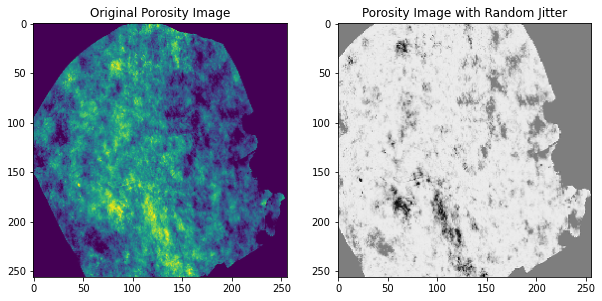

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the correct random crop function for grayscale images
def random_crop(image):
    # Ensure cropping matches the shape of the grayscale images
    cropped_image = tf.image.random_crop(image, size=[256, 256, 1])
    return cropped_image

# Adjust random_jitter function to use the updated random_crop
def random_jitter(image):
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = random_crop(image)
    image = tf.image.random_flip_left_right(image)
    return image

# Retrieve a sample from the train_porosity dataset
sample_porosity = next(iter(train_porosity))

# Visualize the original and augmented image
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.title('Original Porosity Image')
plt.imshow(sample_porosity[0].numpy().squeeze() * 0.5 + 0.5, cmap='gray')  # Rescale to [0, 1] for display

# Apply random jitter for augmentation
augmented_image = random_jitter(sample_porosity[0])

# Augmented Image
plt.subplot(1, 2, 2)
plt.title('Porosity Image with Random Jitter')
plt.imshow(augmented_image.numpy().squeeze() * 0.5 + 0.5, cmap='gray')  # Rescale to [0, 1] for display

plt.show()


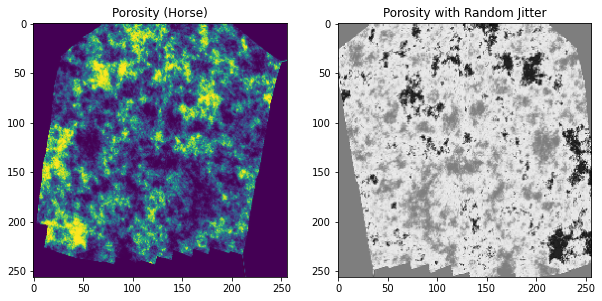

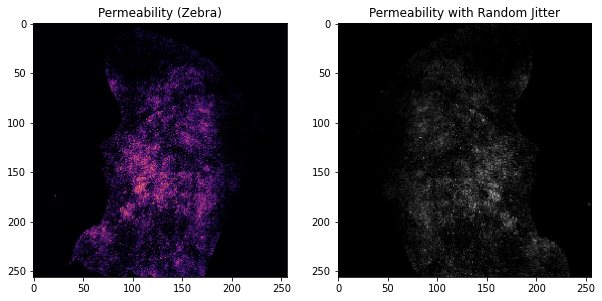

In [9]:
# Retrieve a sample from the train_porosity and train_permeability datasets
sample_porosity = next(iter(train_porosity))
sample_permeability = next(iter(train_permeability))

# Visualize the porosity and permeability images with and without random jitter
plt.figure(figsize=(10, 5))

# Original Porosity Image
plt.subplot(121)
plt.title('Porosity (Horse)')
plt.imshow(sample_porosity[0].numpy().squeeze() * 0.5 + 0.5, cmap='gray')  # Rescale to [0, 1] for display

# Porosity with Random Jitter
jittered_porosity = random_jitter(sample_porosity[0])
plt.subplot(122)
plt.title('Porosity with Random Jitter')
plt.imshow(jittered_porosity.numpy().squeeze() * 0.5 + 0.5, cmap='gray')  # Rescale to [0, 1] for display

plt.show()

# Visualize Permeability Image with and without Random Jitter
plt.figure(figsize=(10, 5))

# Original Permeability Image
plt.subplot(121)
plt.title('Permeability (Zebra)')
plt.imshow(sample_permeability[0].numpy().squeeze() * 0.5 + 0.5, cmap='gray')  # Rescale to [0, 1] for display

# Permeability with Random Jitter
jittered_permeability = random_jitter(sample_permeability[0])
plt.subplot(122)
plt.title('Permeability with Random Jitter')
plt.imshow(jittered_permeability.numpy().squeeze() * 0.5 + 0.5, cmap='gray')  # Rescale to [0, 1] for display

plt.show()


## Import and reuse the Pix2Pix models

Import the generator and the discriminator used in [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) via the installed [tensorflow_examples](https://github.com/tensorflow/examples) package.

The model architecture used in this tutorial is very similar to what was used in [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). Some of the differences are:

* Cyclegan uses [instance normalization](https://arxiv.org/abs/1607.08022) instead of [batch normalization](https://arxiv.org/abs/1502.03167).
* The [CycleGAN paper](https://arxiv.org/abs/1703.10593) uses a modified `resnet` based generator. This tutorial is using a modified `unet` generator for simplicity.

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here. 

* Generator `G` learns to transform image `X` to image `Y`. $(G: X -> Y)$
* Generator `F` learns to transform image `Y` to image `X`. $(F: Y -> X)$
* Discriminator `D_X` learns to differentiate between image `X` and generated image `X` (`F(Y)`).
* Discriminator `D_Y` learns to differentiate between image `Y` and generated image `Y` (`G(X)`).

![Cyclegan model](images/cyclegan_model.png)

In [10]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

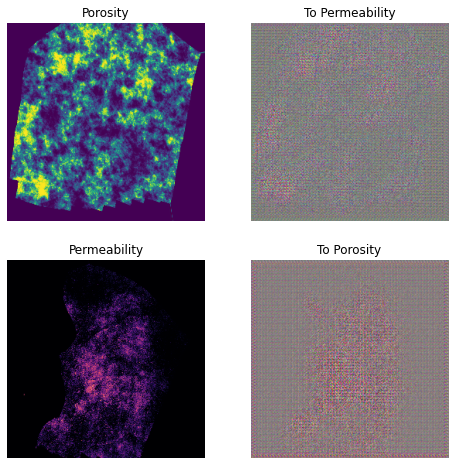

In [33]:
# Preprocess and resize the sample images
sample_porosity_rgb = convert_to_rgb(sample_porosity)
sample_permeability_rgb = convert_to_rgb(sample_permeability)

# Resize images to the expected input size of the model
sample_porosity_rgb = resize_image(sample_porosity_rgb, 256, 256)
sample_permeability_rgb = resize_image(sample_permeability_rgb, 256, 256)

# Ensure the images have the correct shape (batch_size, height, width, channels)
# Add batch dimension only once, if not already present
if len(sample_porosity_rgb.shape) == 3:  # Shape should be (height, width, channels)
    sample_porosity_rgb = tf.expand_dims(sample_porosity_rgb, axis=0)  # Shape: (1, 256, 256, 3)

if len(sample_permeability_rgb.shape) == 3:  # Shape should be (height, width, channels)
    sample_permeability_rgb = tf.expand_dims(sample_permeability_rgb, axis=0)  # Shape: (1, 256, 256, 3)

# Generate transformations using the trained models
to_permeability = generator_g(sample_porosity_rgb, training=False)
to_porosity = generator_f(sample_permeability_rgb, training=False)

# Set up the visualization
plt.figure(figsize=(8, 8))
contrast = 8  # Contrast adjustment for the transformed images

# List of images and titles for display
imgs = [sample_porosity_rgb, to_permeability, sample_permeability_rgb, to_porosity]
titles = ['Porosity', 'To Permeability', 'Permeability', 'To Porosity']

# Display each image
for i, img in enumerate(imgs):
    plt.subplot(2, 2, i + 1)
    plt.title(titles[i])

    # Normalize and display the images
    plt.imshow(img[0].numpy() * 0.5 + 0.5)
    plt.axis('off')  # Remove axis for clarity

# Show the complete plot
plt.show()


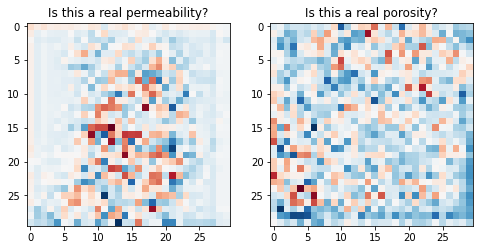

In [34]:
# Set up the plot to display discriminator outputs
plt.figure(figsize=(8, 8))

# Discriminator output for permeability (formerly 'zebra')
plt.subplot(121)
plt.title('Is this a real permeability?')
plt.imshow(discriminator_y(sample_permeability_rgb)[0, ..., -1], cmap='RdBu_r')

# Discriminator output for porosity (formerly 'horse')
plt.subplot(122)
plt.title('Is this a real porosity?')
plt.imshow(discriminator_x(sample_porosity_rgb)[0, ..., -1], cmap='RdBu_r')

# Display the plots
plt.show()


## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator).

In [35]:
LAMBDA = 10

In [36]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [37]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [38]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss, 

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](images/cycle_loss.png)

In [39]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

If you run the zebra-to-horse model on a horse or the horse-to-zebra model on a zebra, it should not modify the image much since the image already contains the target class.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [40]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [41]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [42]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training

Note: This example model is trained for fewer epochs (10) than the paper (200) to keep training time reasonable for this tutorial. The generated images will have much lower quality.

In [63]:
EPOCHS = 10

In [64]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [65]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))


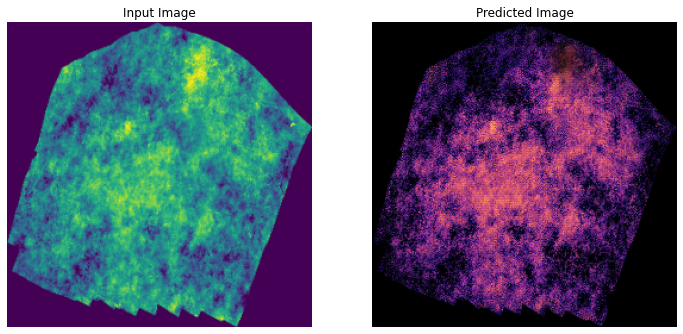

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Time taken for epoch 10 is 956.6258633136749 sec

Generating test images...


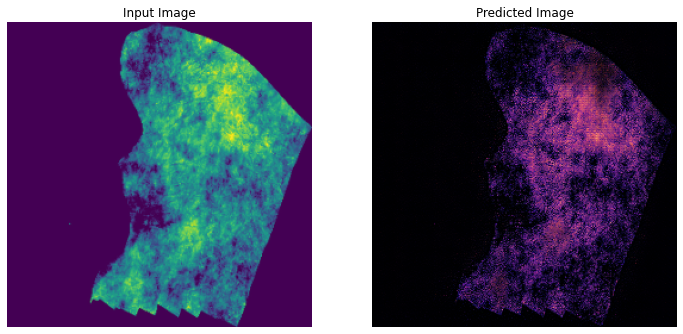

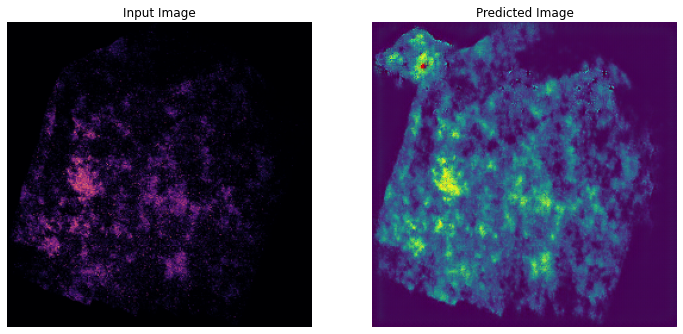

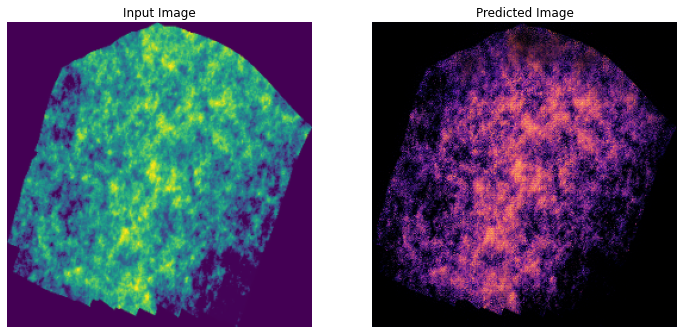

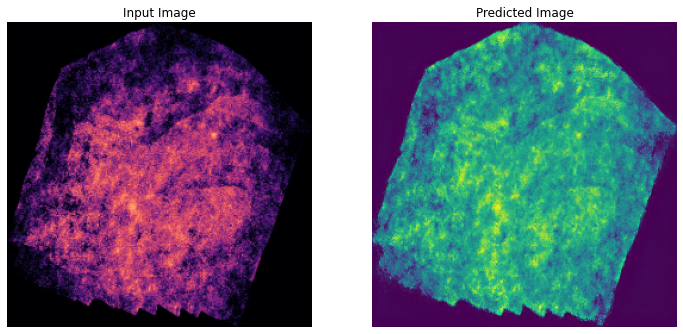

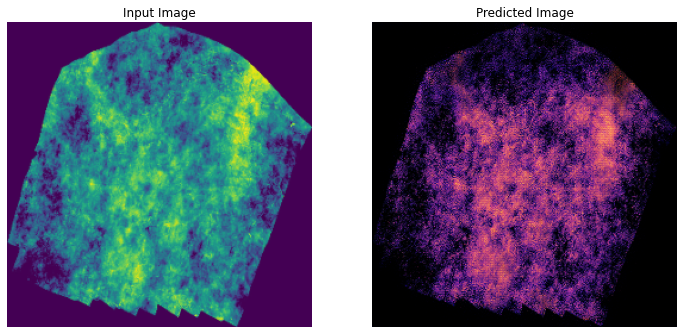

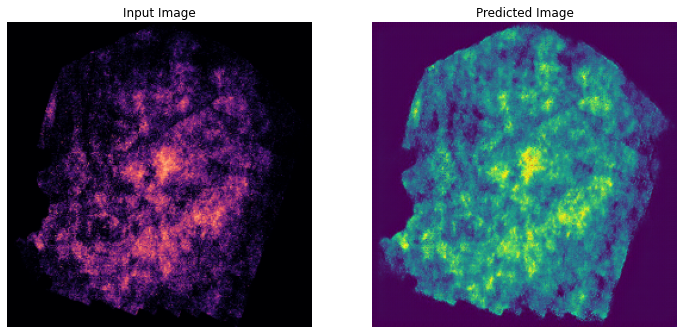

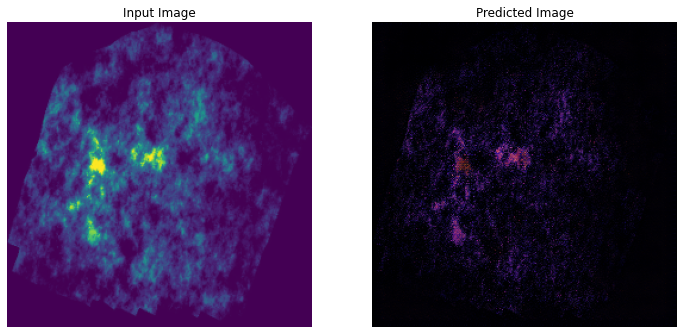

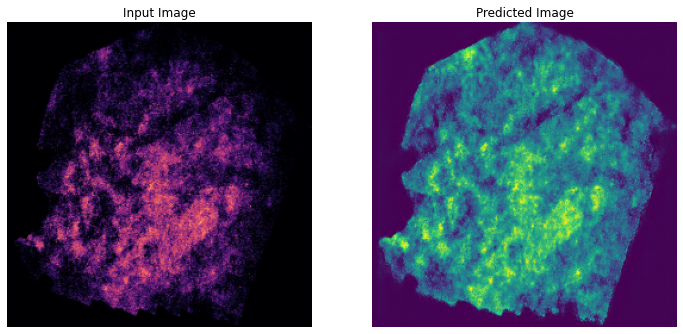

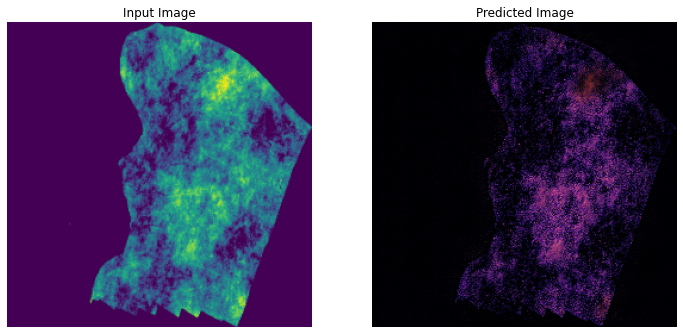

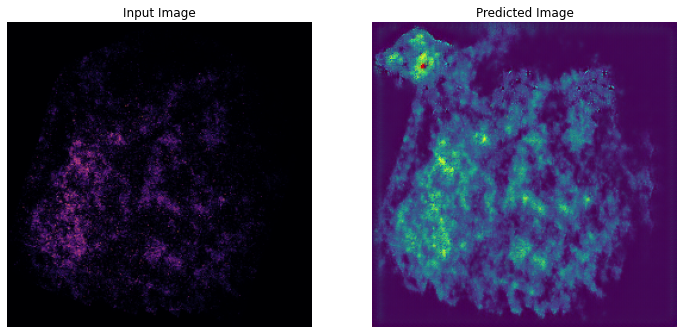

In [66]:
# Training loop with adapted dataset variables
for epoch in range(EPOCHS):
    start = time.time()
    n = 0

    # Use the correct dataset variables for porosity and permeability
    for image_x, image_y in tf.data.Dataset.zip((train_porosity, train_permeability)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    clear_output(wait=True)

    # Visualize progress with a consistent sample from the porosity test set
    sample_test_image = next(iter(test_porosity))
    sample_test_image_resized = tf.image.resize(sample_test_image, [256, 256])
    generate_images(generator_g, sample_test_image_resized)

    # Save the model checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))

    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time() - start))

# Ensure that test images are displayed from both test_porosity and test_permeability sets
print("Generating test images...")
for porosity_img, permeability_img in tf.data.Dataset.zip((test_porosity.take(5), test_permeability.take(5))):
    porosity_resized = tf.image.resize(porosity_img, [256, 256])
    permeability_resized = tf.image.resize(permeability_img, [256, 256])
    generate_images(generator_g, porosity_resized)
    generate_images(generator_f, permeability_resized)


## Generate using test dataset

In [85]:
import os

# Update the generate_images function to save images in high quality
def generate_images(generator_g, generator_f, porosity_input, permeability_input, save_path, file_prefix):
    # Generate predicted images
    pred_permeability = generator_g(porosity_input)
    pred_porosity = generator_f(permeability_input)
    
    # Display real and predicted images
    plt.figure(figsize=(15, 15))

    display_list = [
        porosity_input[0], pred_permeability[0], permeability_input[0], pred_porosity[0]
    ]
    titles = [
        'Real Porosity', 'Predicted Permeability', 'Real Permeability', 'Predicted Porosity'
    ]

    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(titles[i])
        plt.imshow(display_list[i].numpy() * 0.5 + 0.5)  # Scale to [0, 1] for display
        plt.axis('off')

    # Save the figure in high quality
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    save_file_path = os.path.join(save_path, f"{file_prefix}_comparison.png")
    plt.savefig(save_file_path, dpi=300, bbox_inches='tight')  # High DPI for better quality
    plt.close()

# Generate and save images for test datasets
save_directory = "/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/layer match each layer dataset/Cycle GAN/Generating_images"  # Replace this with your desired path
print("Generating and saving high-quality test images...")
for i, (porosity_img, permeability_img) in enumerate(tf.data.Dataset.zip((test_porosity.take(234), test_permeability.take(234)))):
    # Resize images if necessary
    porosity_resized = tf.image.resize(porosity_img, [256, 256])
    permeability_resized = tf.image.resize(permeability_img, [256, 256])

    # Expand dimensions if needed for model input
    if len(porosity_resized.shape) == 3:
        porosity_resized = tf.expand_dims(porosity_resized, axis=0)
    if len(permeability_resized.shape) == 3:
        permeability_resized = tf.expand_dims(permeability_resized, axis=0)

    # Call the updated function and pass a unique file prefix
    generate_images(generator_g, generator_f, porosity_resized, permeability_resized, save_directory, f"test_image_{i+1}")

print(f"High-quality images saved to {save_directory}")


Generating and saving high-quality test images...
High-quality images saved to /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/layer match each layer dataset/Cycle GAN/Generating_images


In [ ]:
for inp in test_porosity.take(5):
    resized_inp = tf.image.resize(inp, [256, 256])  # Resize to 256x256 or the expected input size
    generate_images(generator_g, resized_inp)


## Next steps

This tutorial has shown how to implement CycleGAN starting from the generator and discriminator implemented in the [Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorial. As a next step, you could try using a different dataset from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/cycle_gan). 

You could also train for a larger number of epochs to improve the results, or you could implement the modified ResNet generator used in the [paper](https://arxiv.org/abs/1703.10593) instead of the U-Net generator used here.

In [ ]:
/home/g202103050/Downloads/Microstructure-GAN-main